# Time series forecasting

### Importing libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.rc('font', size=16)
plt.style.use('fivethirtyeight')




2.15.0


## Data loading
We use numpy to first load the .npy files and then make them into dataframes for easier manipulation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /gdrive/My Drive/Colab Notebooks/RedstoneRookies/Homework_2

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/gdrive/My Drive/Colab Notebooks/RedstoneRookies/Homework_2'
/content


In [ ]:
npz_categories = np.load("/content/gdrive/MyDrive/Colab Notebooks/RedstoneRookies/Homework_2/Training_data/categories.npy")
npz_training_data = np.load("/content/gdrive/MyDrive/Colab Notebooks/RedstoneRookies/Homework_2/Training_data/training_data.npy")
npz_valid_periods = np.load("/content/gdrive/MyDrive/Colab Notebooks/RedstoneRookies/Homework_2/Training_data/valid_periods.npy")

In [ ]:
categories_df = pd.DataFrame(npz_categories, columns=["category"])
print(categories_df["category"].unique())
categories_df.head(20)

['D' 'E' 'A' 'C' 'B' 'F']


,category
0,D
1,D
2,D
3,D
4,D
5,D
6,D
7,D
8,D
9,D


In [ ]:
raw_train_df = pd.DataFrame(npz_training_data)
raw_train_df

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.478704,0.412963,0.501852,0.756481,0.744444,0.640741,0.516667,0.602778,0.367593,0.331481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.628000,0.624000,0.644000,0.688000,0.740000,0.640000,0.536000,0.600000,0.460000,0.396000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.959741,0.949098,0.919297,0.916705,0.901249,0.932531,0.955206,0.960481,0.946506,0.977140
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.411765,0.307030,0.325681,0.361549,0.430416,0.486370,0.450502,0.470588,0.569584,0.571019
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.340909,0.522727,0.568182,0.772727,0.681818,0.704545,0.863636,0.727273,0.818182,0.840909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.231879,0.327495,0.146178,0.136704,0.240361,0.319784,0.447455,0.454175,0.623485,0.013329
47996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.656293,0.624932,0.521640,0.572263,0.617589,0.494914,0.504665,0.504545,0.521760,0.091133
47997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.414474,0.480263,0.513158,0.559211,0.565789,0.588816,0.625000,0.526316,0.582237,0.552632
47998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.316062,0.481865,0.554404,0.414508,0.492228,0.523316,0.445596,0.445596,0.585492,0.404145


In [ ]:
valid_periods_df = pd.DataFrame(npz_valid_periods, columns=["valid_period_start", "valid_period_end"])
valid_periods_df

,valid_period_start,valid_period_end
0,2325,2776
1,2325,2776
2,2325,2776
3,2712,2776
4,2682,2776
...,...,...
47995,2642,2776
47996,2642,2776
47997,2676,2776
47998,2676,2776


## Data exploration
Then we explore the data too see if we can spot any patterns or errors we can utilize in our model

In [ ]:
def plot_histogram(df, column_name):
  # Plotting the histogram using Seaborn
  plt.figure(figsize=(10, 6))
  sns.histplot(df[column_name], bins=30)
  plt.title(f'Histogram of {column_name}', fontsize=16)
  plt.xlabel(column_name, fontsize=14)
  plt.ylabel('Frequency', fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  sns.despine()  # Remove the right and top spines for better aesthetics
  plt.show()

### Distribution of categories
We look into the distribution of categories in our dataset

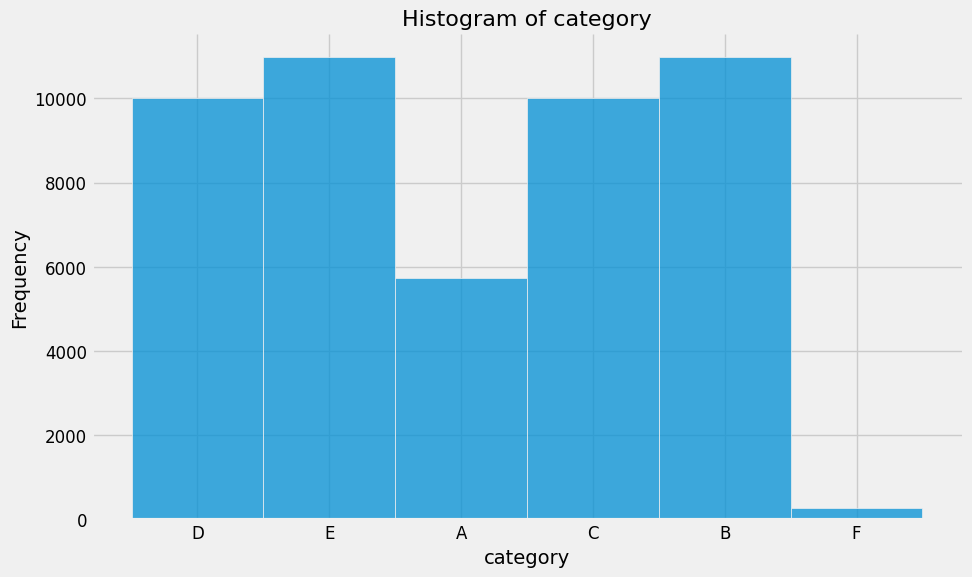

In [ ]:
plot_histogram(categories_df, column_name="category")

As we can see, there is some strong unbalance in the different categories provided in the dataset. So far it is unclear if this will affect our training of the model in any way, as the categories might not have anything to do with the shape of the timeseries

In [ ]:
valid_periods_df

,valid_period_start,valid_period_end
0,2325,2776
1,2325,2776
2,2325,2776
3,2712,2776
4,2682,2776
...,...,...
47995,2642,2776
47996,2642,2776
47997,2676,2776
47998,2676,2776


### Distribution of how long the different periods are
We then look at each timeseries length of periods. We notice that alot of the timeseries lay below 209 (window_size + telescope in phase 1) and 218 (window_size + telescope in phase 2). This shows that we can't simply discard timeseries that are not valid in this period, as our training set would drastically decrease in size.

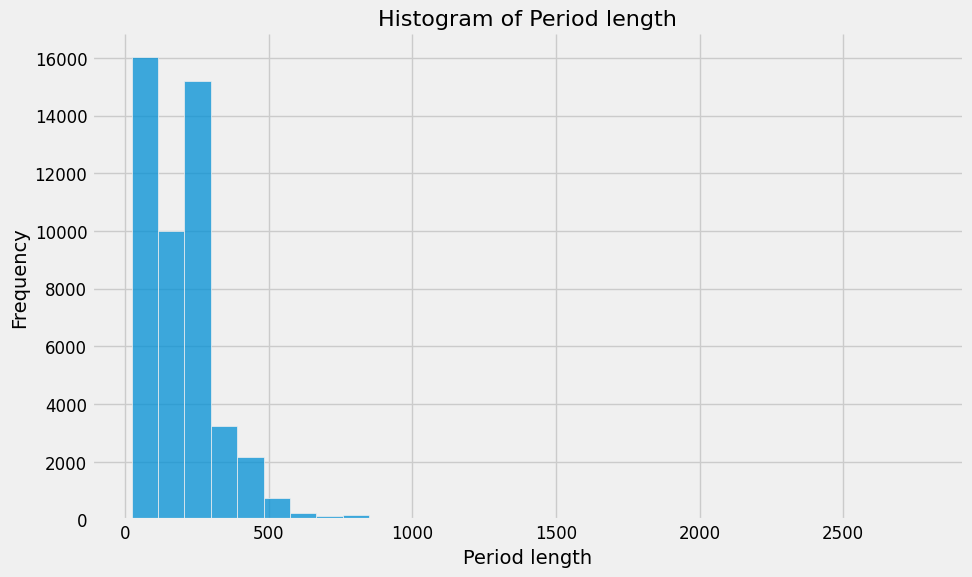

In [ ]:
valid_periods_df["Period length"] = valid_periods_df["valid_period_end"] - valid_periods_df["valid_period_start"]
plot_histogram(valid_periods_df, "Period length")

## Data visualization
We visualize timeseries from different catefories to understand the patterns and characteristics of each category

In [ ]:
timeseries_df = raw_train_df

In [ ]:
def random_plot(category, number=5, valid_periods_df=valid_periods_df):
    # Extract indexes of 5 random entries where the value in column "0" is the specified category
    indices = categories_df.index[categories_df["category"] == category].tolist()
    random_indices = np.random.choice(indices, size=number, replace=False)

    # Retrieve time series from df using the selected indexes
    selected_time_series = timeseries_df.iloc[random_indices, :2776]  # Assuming 2776 is the time series length

    # Visualize the time series in subplots using Seaborn
    fig, axes = plt.subplots(number, 1, figsize=(10, 3 * number), sharex=False)

    for i, (index, row) in enumerate(selected_time_series.iterrows()):
        # Get the valid interval for the current time series
        valid_interval = valid_periods_df.loc[index]

        # Zoom in on the valid interval
        zoomed_row = row.loc[valid_interval[0]:valid_interval[1]]

        sns.lineplot(x=zoomed_row.index, y=zoomed_row.values, ax=axes[i])
        axes[i].set_title(f'Time Series {index} (Category {category}) - Valid Interval')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Values')

    plt.tight_layout()
    plt.show()

### Category A


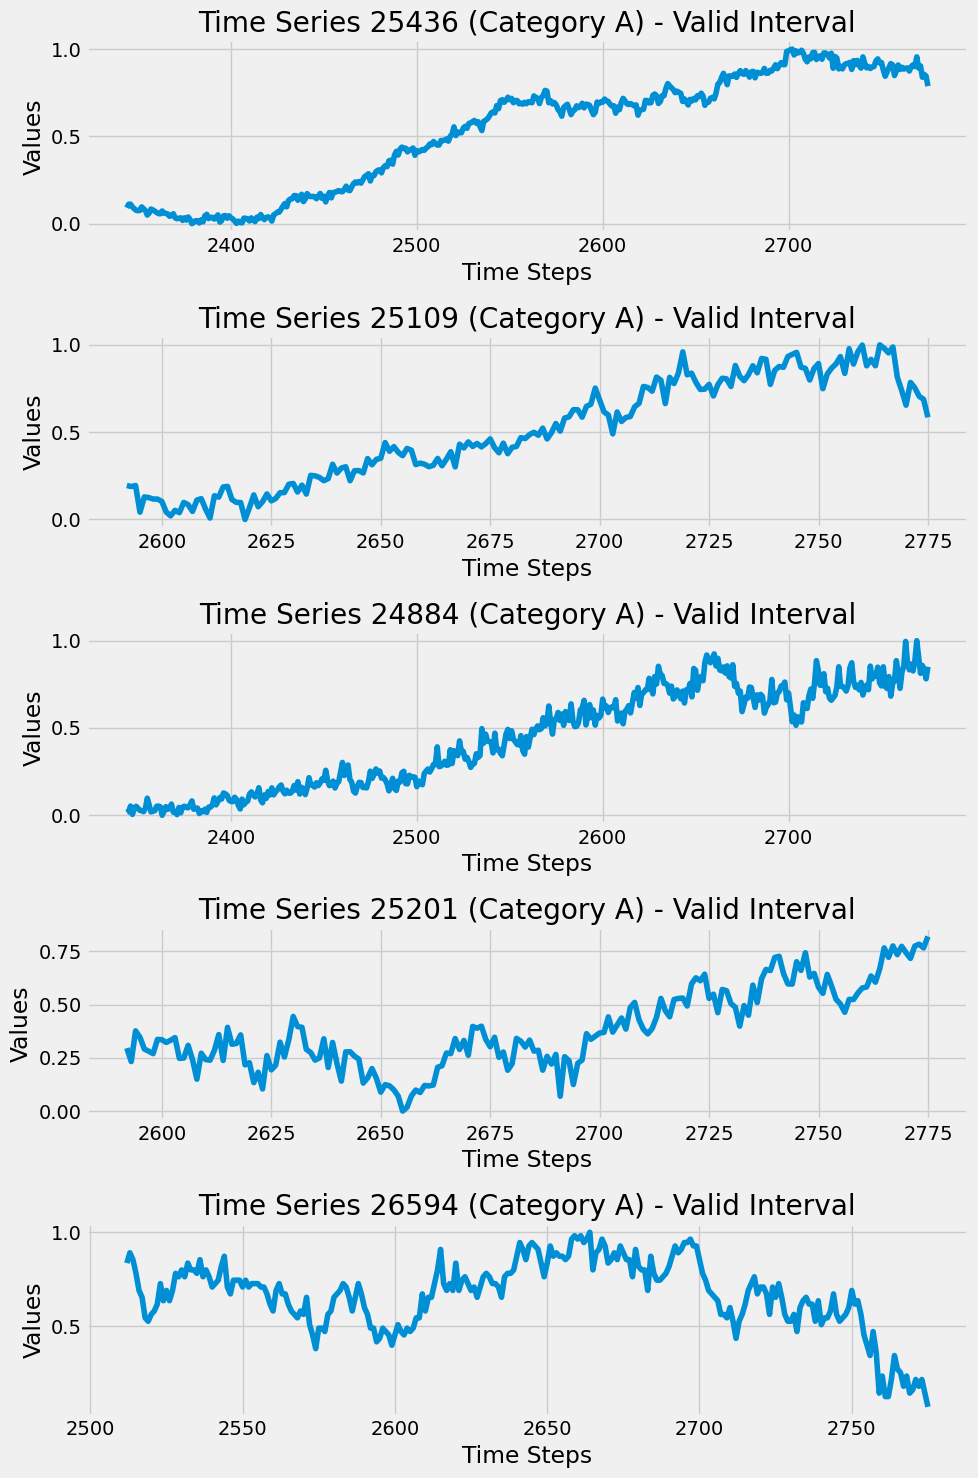

In [ ]:
random_plot(category="A", number=5)

### Category B

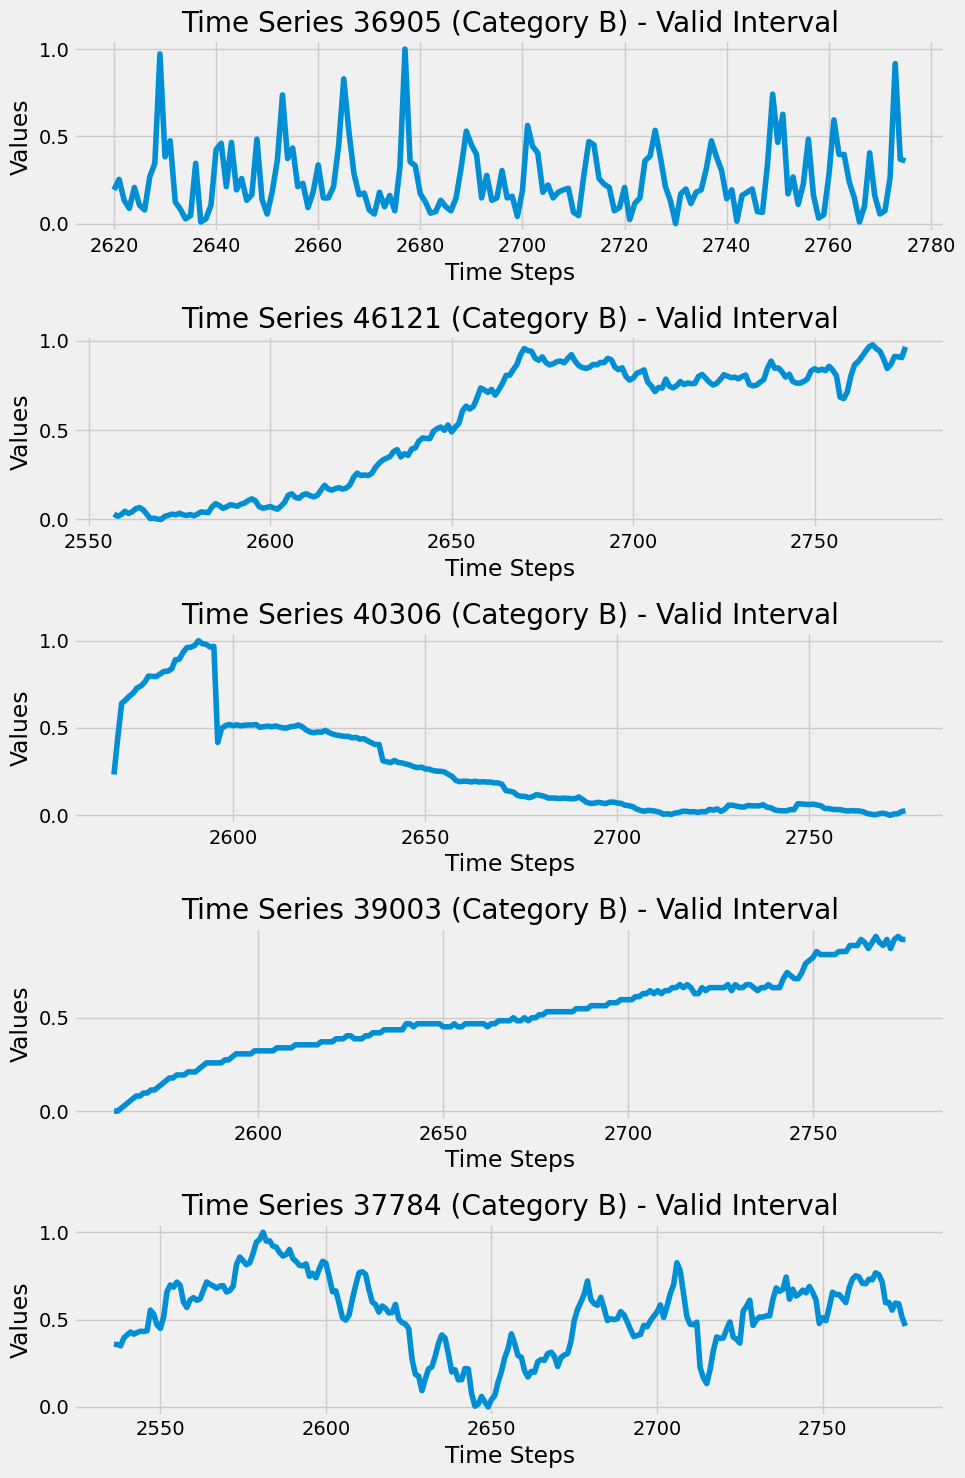

In [ ]:
random_plot(category="B", number=5)

### Category C


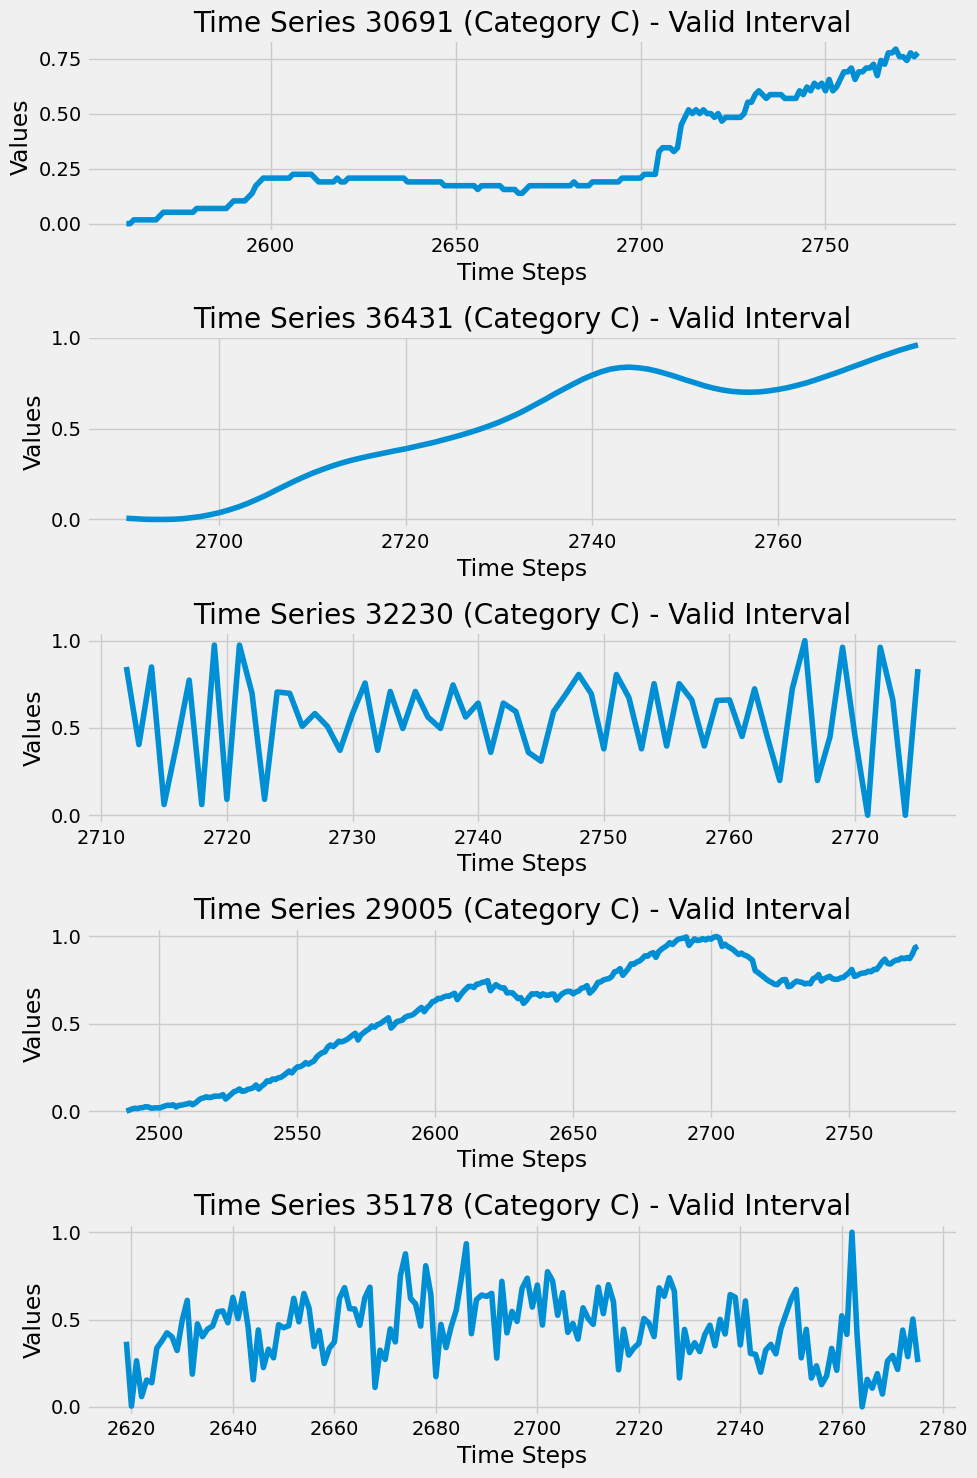

In [ ]:
random_plot(category="C", number=5)

### Category D

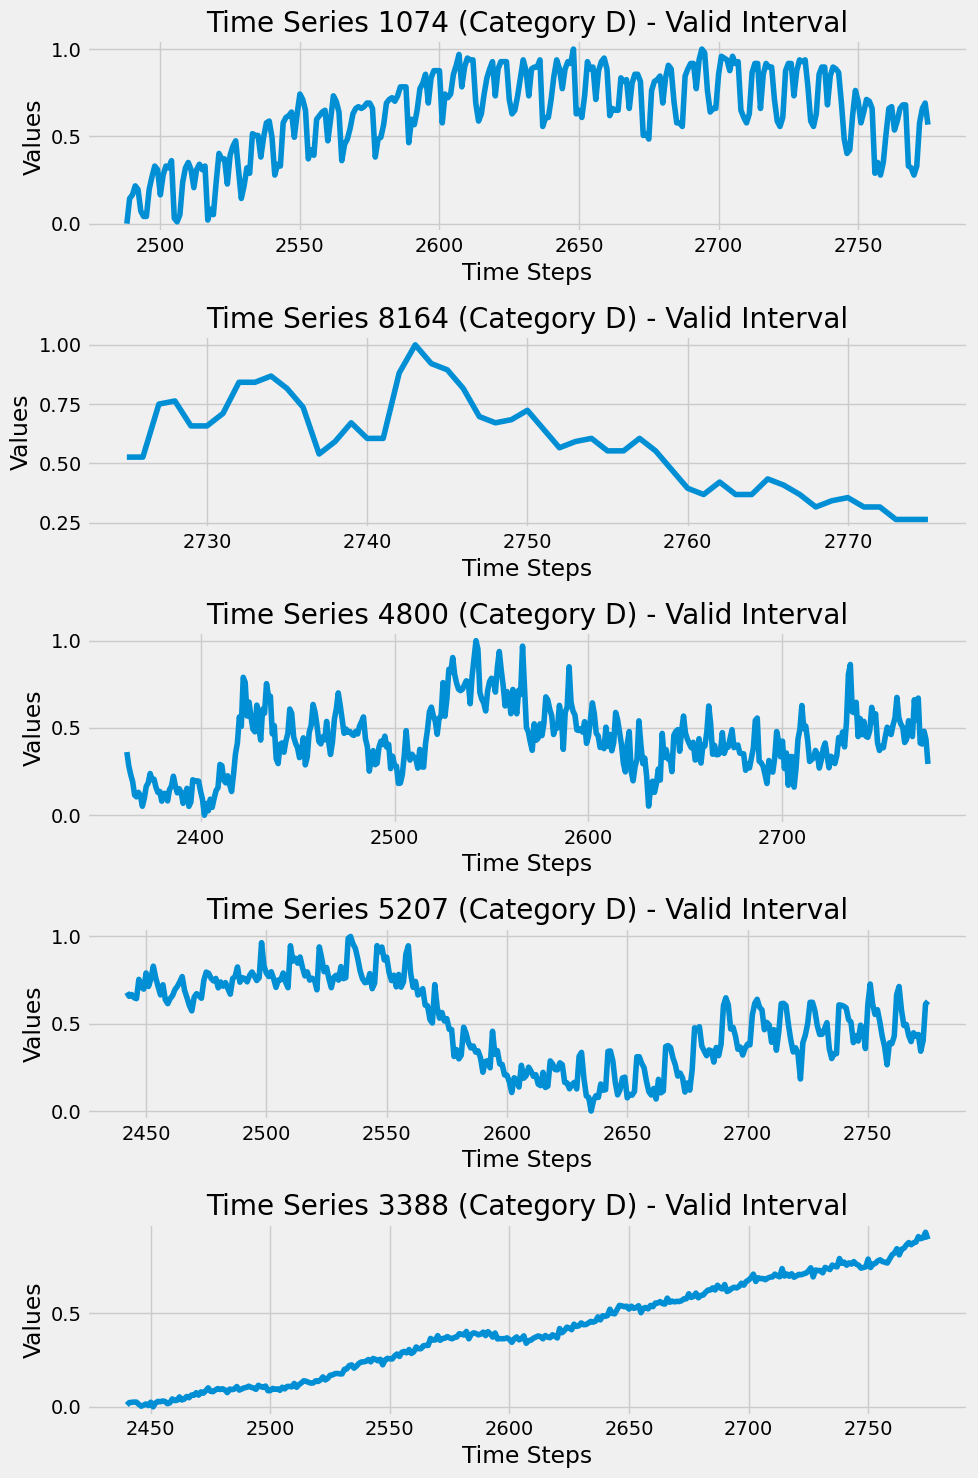

In [ ]:
random_plot(category="D", number=5)

### Category E

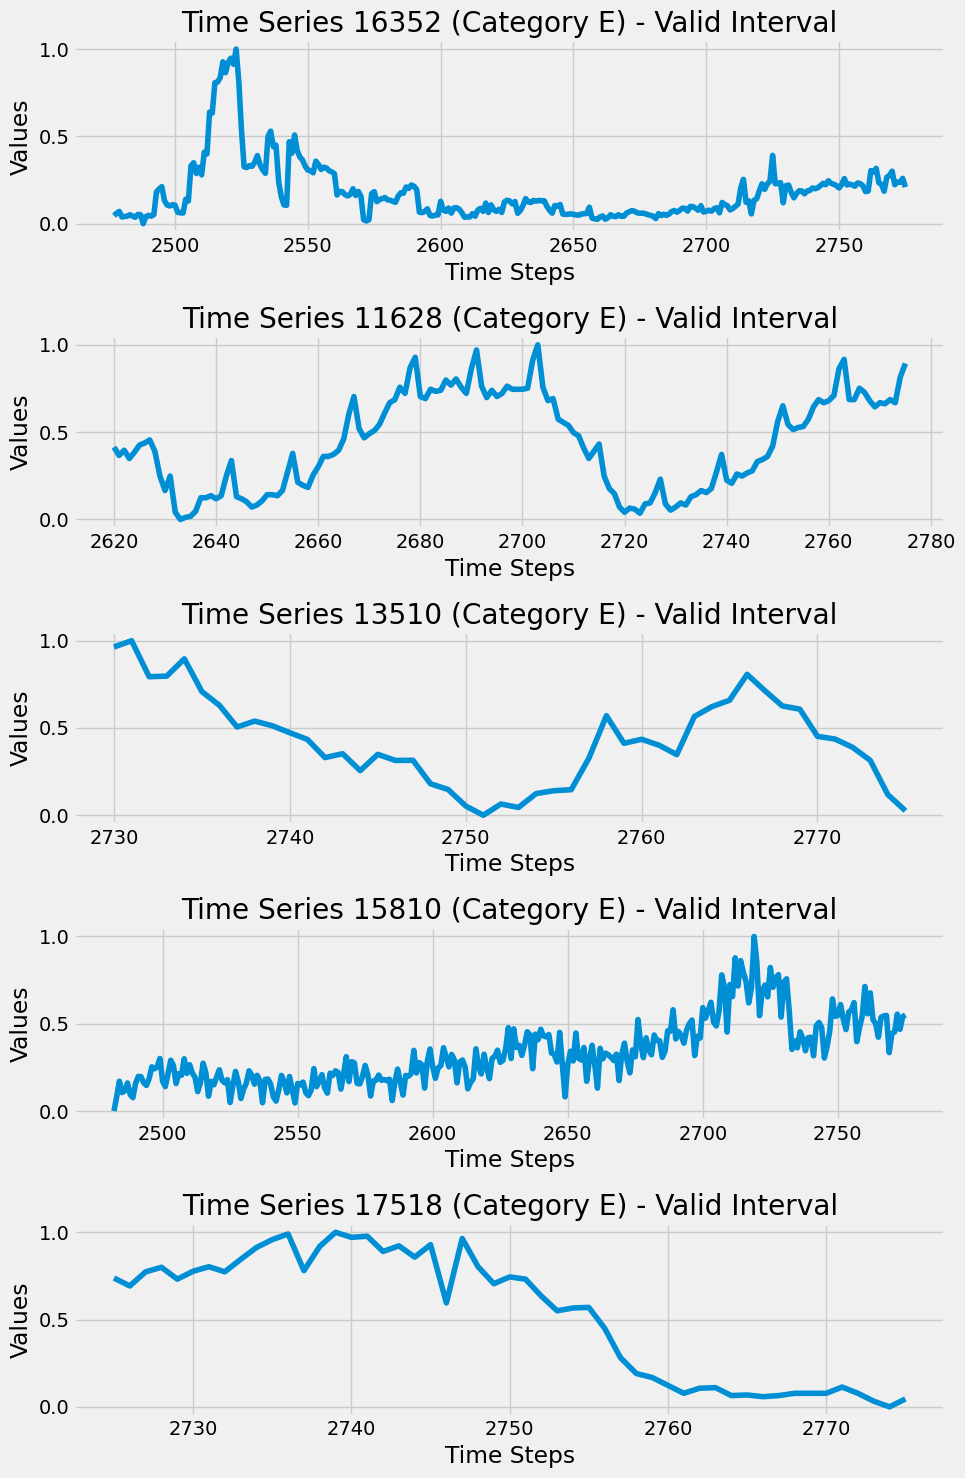

In [ ]:
random_plot(category="E", number=5)

### Category F

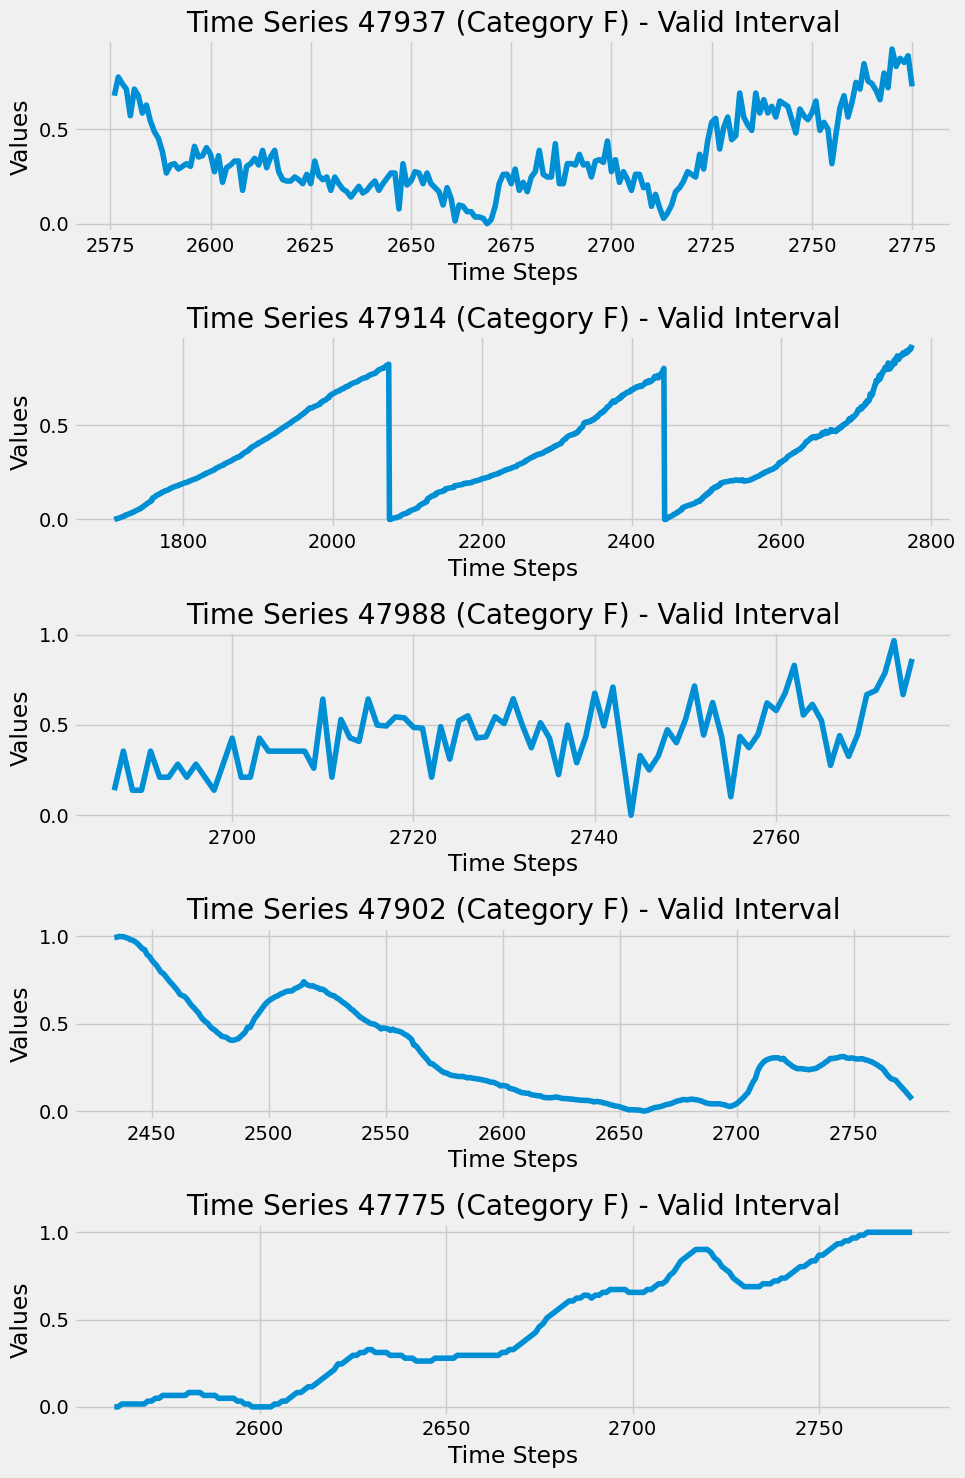

In [ ]:
random_plot(category="F", number=5)

# Building sequences


First of all we would want to split the data into train and test sets. This does not take into consideration the distribution of categories. So this will be different in training and testing sets. But due to the results we saw in the data exploration phase where it looked like there was no similiarities between timeseries in the same category, this will be completely fine.

We also keep the entire collection since we want to train the model on all the data before submitting.

In [ ]:
train_test_ratio = 0.1

test_timeseries_df = timeseries_df.sample(frac=0.1, random_state=42)
train_timeseries_df = timeseries_df.drop(test_timeseries_df.index)

Currently each row of the frame corresponds to a timeseries. We want to change this to make it easier to work with. By transposing the dataframe each column is a timeseries. I,e. doing df[20] gives us timeseries 20. This makes things easier while doing sequencing

In [ ]:
train_timeseries_df = train_timeseries_df.T
test_timeseries_df = test_timeseries_df.T
timeseries_df = timeseries_df.T

In [ ]:
train_timeseries_df.isna().sum().sum() # Test for NA values

0

When doing sampling we would like to have the following properties of the output data:
- The data should be within "valid period"
- The sample window should be 200
- The sample telescope should be 9 for phase 1, 18 for phase 2
- We will have a stride of 100 for our window


### With padding

In [ ]:
from tqdm import tqdm
# With padding
def build_univariate_sequences(df, valid_periods, window=200, telescope=9, stride=100):
  num_padded_timeseries = 0
  index_of_one_padded_timeseries = 0
  dataset = []
  labels = []
  print("Building sequences from timeseries...")
  for timeseries in tqdm(df.columns):
    # Load period data for the given timeseries
    start = valid_periods.iloc[timeseries]["valid_period_start"]
    end = valid_periods.iloc[timeseries]["valid_period_end"]
    period_length = valid_periods.iloc[timeseries]["Period length"]
    category = categories_df.iloc[timeseries]["category"]

    timeseries_to_process = df[timeseries].values

    # Add padding if the period is shorter than what we expect
    if period_length < window + telescope:
      padding_size = window + telescope - period_length
      timeseries_to_process = np.pad(timeseries_to_process, (0, padding_size), mode='constant')
      start = start - padding_size

    # Slide the window forward by stride for as long as we can
    while start + window + telescope <= end:
      # Extract sequence and label
      sequence = timeseries_to_process[start:start + window]
      label = timeseries_to_process[start + window:start + window + telescope]

      # Convert to numpy arrays and reshape. Adding dimension 1 gives us no information. Should contain the class
      dataset.append(sequence.reshape(window, 1))
      labels.append(label.reshape(telescope))

      start = start + stride

  print(f"\nDone building {len(dataset)} sequences!")
  return np.array(dataset), np.array(labels)

In [ ]:
X_train, y_train = build_univariate_sequences(train_timeseries_df, valid_periods_df, telescope=18)

Building sequences from timeseries...


100%|██████████| 43200/43200 [00:12<00:00, 3406.85it/s]



Done building 52407 sequences!


In [ ]:
X_test, y_test = build_univariate_sequences(test_timeseries_df, valid_periods_df,telescope=18)

Building sequences from timeseries...


100%|██████████| 4800/4800 [00:01<00:00, 3081.05it/s]


Done building 5840 sequences!


In [ ]:
X_total, y_total = build_univariate_sequences(timeseries_df, valid_periods_df,telescope=18)

Building sequences from timeseries...


100%|██████████| 48000/48000 [00:11<00:00, 4340.53it/s]



Done building 58247 sequences!


In [ ]:
X_train.shape, y_train.shape

((52407, 200, 1), (52407, 18))

In [ ]:
X_test.shape, y_test.shape

((5840, 200, 1), (5840, 18))

In [ ]:
valid_periods_df[valid_periods_df['Period length']<100].index # For potentially removing

Int64Index([    3,     4,     6,     7,   105,   108,   109,   110,   111,
              130,
            ...
            47903, 47978, 47979, 47981, 47988, 47989, 47991, 47992, 47993,
            47994],
           dtype='int64', length=15395)

In [ ]:
X_train_df = pd.DataFrame(pd.DataFrame(X_train.reshape(X_train.shape[0],X_train.shape[1])))

## Normalising data further with robust and z normalization

In [ ]:
def robust_scale(numpy_array):
    # df = pd.DataFrame(numpy_array.reshape(numpy_array.shape[0],numpy_array.shape[1]))
    # Function to calculate IQR
    def iqr(series):
        return np.quantile(series, 0.75, keepdims=True) - np.quantile(series, 0.25, keepdims=True)

    # Calculate the median and IQR for each row
    median = np.median(numpy_array, axis=1, keepdims=True)
    iqr_values = np.apply_along_axis(iqr, axis=1, arr=numpy_array)
    iqr_values[iqr_values == 0] = 1/np.abs(median[iqr_values == 0])*1e-3

    # Scale each element
    scaled_array = (numpy_array - median) / iqr_values
    # a[~np.isnan(a).any(axis=1)]
    # fin_bool = np.array([np.ones(row.shape) if (row!=0).any() else np.zeros(row.shape) for row in iqr_values])
    # scaled_array = np.array([row for row in scaled_array if np.isfinite(row).all()])
    # median = median[fin_bool==1]
    # iqr_values = iqr_values[fin_bool==1]

    # scaled_df = df.subtract(median, axis='rows').divide(iqr_values, axis='rows')

    # Reformat to numpy array
    # scaled_df = np.array(scaled_df)
    # scaled_df = scaled_df.reshape(scaled_df.shape[0], scaled_df.shape[1], 1)
    # return scaled_df, np.array(median), np.array(iqr_values)
    return scaled_array, median, iqr_values


In [ ]:
def z_scale(numpy_array):

    # Calculate the median and IQR for each row
    means = np.mean(numpy_array, axis=1, keepdims=True)
    stds = np.std(numpy_array, axis=1, keepdims=True)

    stds[stds == 0] = 1/means[stds==0] *1e-3
    # # Scale each element
    scaled_array = (numpy_array - means)/ stds

    return scaled_array, np.array(means), np.array(stds)

In [ ]:
# z_scaled_df, z_means, z_sds = z_scale(X_train)
# np.mean(z_scaled_df,axis=1)

In [ ]:
def z_scale_inverse(numpy_array, mean, stds):
  return numpy_array * stds + mean

In [ ]:
def inverse_robust_scaling(numpy_array, medians, iqrs):
    inv_arr = numpy_array*iqrs + medians
    return inv_arr

In [ ]:
# inversed_scaled = inverse_robust_scaling(robust_scaled_array, robust_medians, robust_iqrs)

In [ ]:
# (inversed_scaled - X_train[:1000,:,:])[np.isfinite(inversed_scaled)].sum()

# Plotting samples of sequences
To be sure that everything went as expected when building sequences,, we plot 5 random sequences.

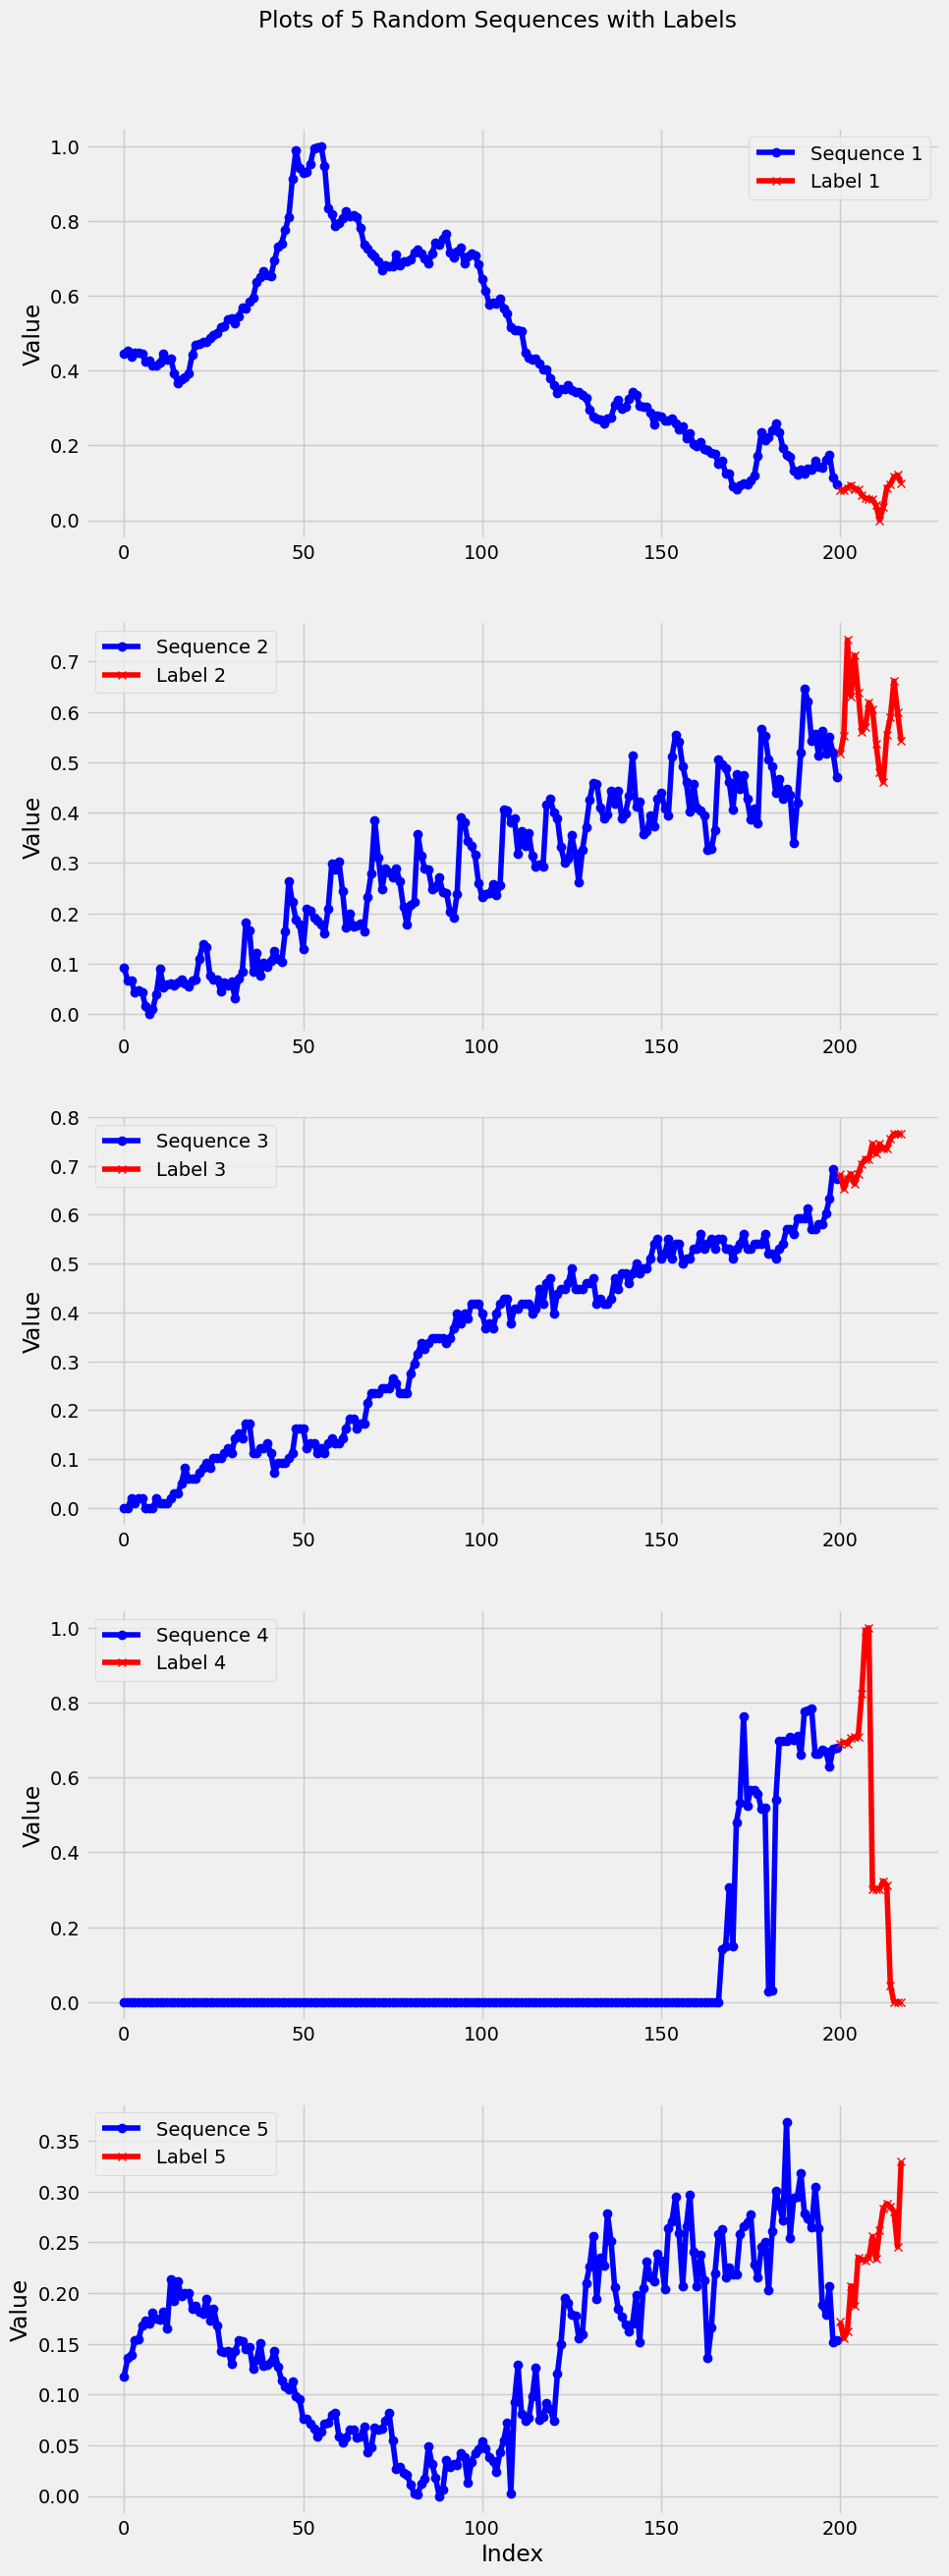

In [ ]:
def plot_random_sequences_with_labels(sequences, labels, num_to_plot=5):
  """
  Plot a random subset of sequences with corresponding labels in individual subplots.

  Parameters:
  - sequences (numpy array): Numpy array where each element represents a sequence to be plotted.
  - labels (numpy array): Numpy array where each element represents labels corresponding to the sequences.
  - num_to_plot (int): Number of sequences to plot. Default is 5.
  """

  # Check if the number of sequences to plot is greater than the length of the input list
  num_to_plot = min(num_to_plot, len(sequences))

  # Randomly select sequences to plot
  selected_indices = random.sample(range(len(sequences)), num_to_plot)

  # Create subplots without sharing x-axis
  fig, axes = plt.subplots(num_to_plot, 1, figsize=(10, 6 * num_to_plot))

  # Plot each selected sequence and its corresponding label in a separate subplot
  for i, idx in enumerate(selected_indices):
      sequence = sequences[idx]
      label = labels[idx]

      # Plot sequence in blue
      axes[i].plot(range(len(sequence)), sequence, marker='o', linestyle='-', label=f'Sequence {i + 1}', color='blue')

      # Plot label in red
      axes[i].plot(range(len(sequence), len(sequence) + len(label)), label, marker='x', linestyle='-', label=f'Label {i + 1}', color='red')

      axes[i].set_ylabel('Value')
      axes[i].legend()

  # Set common xlabel and title
  plt.xlabel('Index')
  plt.suptitle(f'Plots of {num_to_plot} Random Sequences with Labels', y=0.92)

  # Show the plot
  plt.show()


plot_random_sequences_with_labels(X_train, y_train)

As we see the training sequence and label seems to be matched correctly. Everything looks fine.

# Model Architecture



## Predictions

In [ ]:
def calculate_error_of_model(model, X_test, y_test):
  # Predict the test set using the model
  predictions = model.predict(X_test, verbose=0)

  # Print the shape of the predictions
  print(f"Predictions shape: {predictions.shape}")

  # Calculate and print Mean Squared Error (MSE)
  mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error: {mean_squared_error}")

  # Calculate and print Mean Absolute Error (MAE)
  mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
  print(f"Mean Absolute Error: {mean_absolute_error}")

## Baseline
Model for predicting the last seen value of the timeseries for 9 (18 phase 2) steps in the future. This will be used for comparisons

In [ ]:
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
y_train[:,1].shape
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1]))
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1]))

In [ ]:
def replicate_last_column(dataframe, reps=18):
    """
    Takes a DataFrame and returns a new DataFrame with reps columns
    that are the same as the last column in the input DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A new DataFrame with reps columns, all replicating the last column of the input DataFrame.
    """
    if dataframe.empty or dataframe.columns.empty:
        return pd.DataFrame()

    last_column = dataframe.iloc[:, -1]  # Select the last column
    new_dataframe = pd.concat([last_column] * reps, axis=1)  # Replicate the last column 9 times
    new_dataframe.columns = [f'{i}' for i in range(reps)]  # Rename the columns


    return new_dataframe

from sklearn.metrics import mean_absolute_error

new_df = replicate_last_column(X_test_df, reps = 18)
print(mean_squared_error(new_df, y_test_df)) # Flat predictor mse
print(mean_absolute_error(new_df, y_test_df)) # Flat predictor mae


0.029163794655219344
0.11378589291930802


## Very simple LSTM
A very shallow and not to wide LSTM network to test it's performance and see if it is promising

In [ ]:
input_shape = X_train.shape
output_shape = y_train.shape[1]
batch_size = 64
epochs = 500 # Pessimistic
input_shape, output_shape

((52407, 200, 1), 18)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

def build_simple_LSTM(input_shape, output_shape):

  # Create an LSTM model
  input_layer = Input(shape=(input_shape[1:]))
  x = LSTM(units=200)(input_layer)
  output_layer = Dense(units=output_shape)(x)

  model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  return model

In [ ]:
model = build_simple_LSTM(input_shape, output_shape)

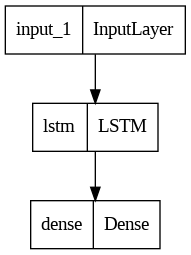

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/500
737/737 [==============================] - 13s 14ms/step - loss: 0.0265 - val_loss: 0.0366 - lr: 0.0010
Epoch 2/500
737/737 [==============================] - 9s 12ms/step - loss: 0.0203 - val_loss: 0.0355 - lr: 0.0010
Epoch 3/500
737/737 [==============================] - 10s 13ms/step - loss: 0.0196 - val_loss: 0.0350 - lr: 0.0010
Epoch 4/500
737/737 [==============================] - 9s 13ms/step - loss: 0.0184 - val_loss: 0.0348 - lr: 0.0010
Epoch 5/500
737/737 [==============================] - 9s 13ms/step - loss: 0.0178 - val_loss: 0.0329 - lr: 0.0010
Epoch 6/500
737/737 [==============================] - 10s 13ms/step - loss: 0.0174 - val_loss: 0.0331 - lr: 0.0010
Epoch 7/500
737/737 [==============================] - 10s 13ms/step - loss: 0.0171 - val_loss: 0.0318 - lr: 0.0010
Epoch 8/500
737/737 [==============================] - 11s 15ms/step - loss: 0.0171 - val_loss: 0.0333 - lr: 0.0010
Epoch 9/500
737/737 [==============================] - 12s 16ms/step - loss

In [ ]:
def model_history_plot(model_history):
  best_epoch = np.argmin(model_history['val_loss'])
  plt.figure(figsize=(17,4))
  plt.plot(model_history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
  plt.plot(model_history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.title('Mean Squared Error')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

  plt.figure(figsize=(18,3))
  plt.plot(model_history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

  print(f"Lowest validation loss: {round(np.min(model_history['val_loss']),6)}")
  print(f"Lowest training loss: {round(np.min(model_history['loss']),6)}")

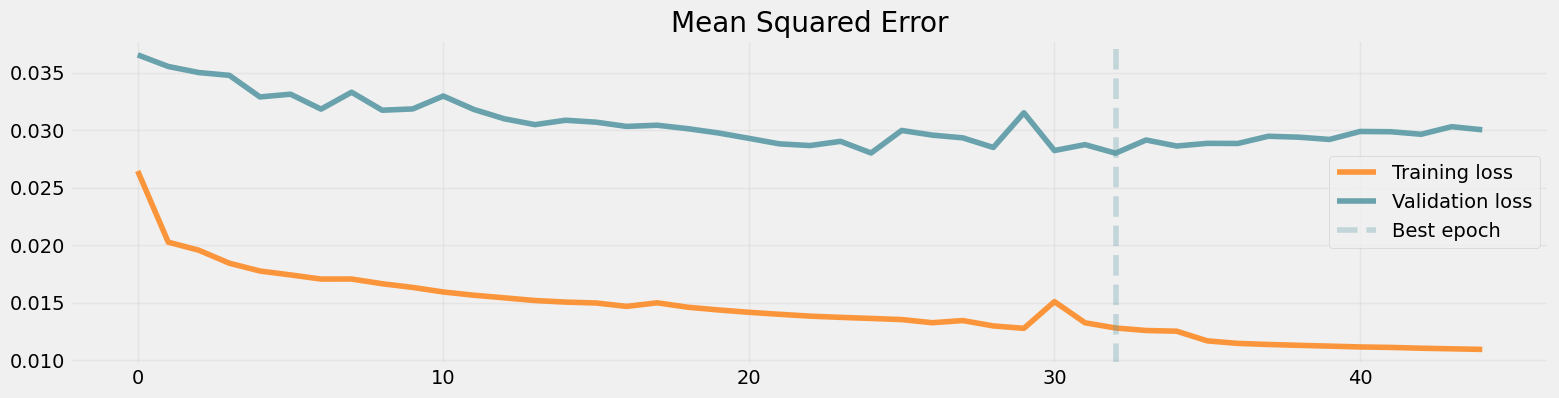

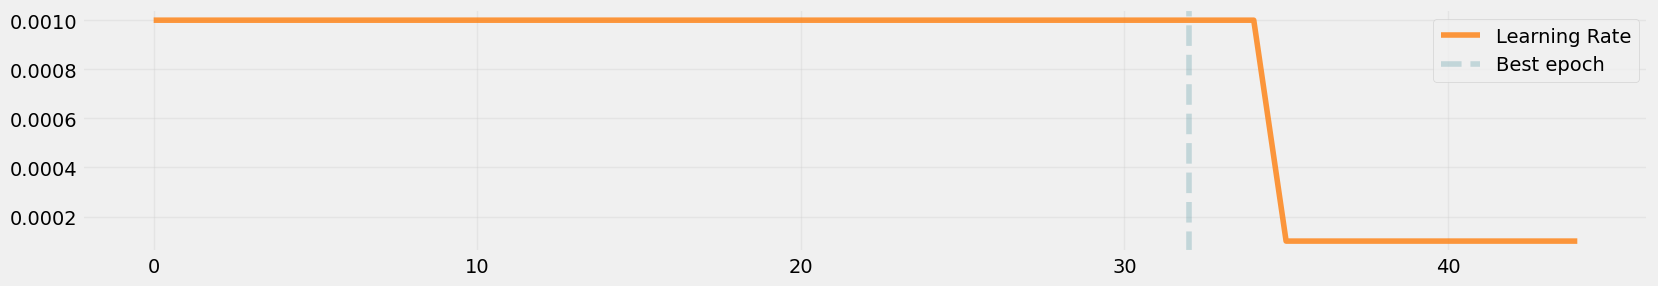

Lowest validation loss: 0.028002
Lowest training loss: 0.010941


In [ ]:
model_history_plot(history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save("/content/drive/MyDrive/Colab Notebooks/RedstoneRookies/Homework_2/SimpleLSTM.h5")

Mounted at /content/drive


In [ ]:
calculate_error_of_model(model, X_test, y_test)
del model

Predictions shape: (5840, 18)
Mean Squared Error: 0.01444265153259039
Mean Absolute Error: 0.08051533997058868


## 1D CNN LSTM
Model using 1 dimensional convolutional layers before the LSTM layer with dropout and batch-normalization to prevent overfitting. This is model (v2 + v3) in the report.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, BatchNormalization

def build_CONV_LSTM_model(input_shape, output_shape):
    # Define the input layer with shape 200
    input_layer = Input(shape=(input_shape[1:]), name = 'input_layer')

    # Conv layers
    x = tfkl.Conv1D(filters=32, kernel_size=3, activation='relu', name='conv1')(input_layer)
    x = BatchNormalization(name='batch_norm1')(x)
    x = tfkl.Dropout(0.2, name='dropout1')(x)
    x = tfkl.Conv1D(filters=64, kernel_size=3, activation='relu', name='conv2')(x)
    x = BatchNormalization(name='batch_norm2')(x)

    # LSTM
    x = LSTM(units = 128, name="lstm")(x)

    x = tfkl.Dropout(0.2, name='dropout2')(x)

    # Output
    output_layer = Dense(units=output_shape)(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Epoch 1/500
737/737 [==============================] - 17s 13ms/step - loss: 0.0295 - val_loss: 0.0337 - lr: 0.0010
Epoch 2/500
737/737 [==============================] - 10s 13ms/step - loss: 0.0199 - val_loss: 0.0290 - lr: 0.0010
Epoch 3/500
737/737 [==============================] - 10s 13ms/step - loss: 0.0182 - val_loss: 0.0279 - lr: 0.0010
Epoch 4/500
737/737 [==============================] - 9s 12ms/step - loss: 0.0173 - val_loss: 0.0288 - lr: 0.0010
Epoch 5/500
737/737 [==============================] - 10s 13ms/step - loss: 0.0167 - val_loss: 0.0298 - lr: 0.0010
Epoch 6/500
737/737 [==============================] - 9s 12ms/step - loss: 0.0161 - val_loss: 0.0265 - lr: 0.0010
Epoch 7/500
737/737 [==============================] - 9s 12ms/step - loss: 0.0156 - val_loss: 0.0269 - lr: 0.0010
Epoch 8/500
737/737 [==============================] - 10s 13ms/step - loss: 0.0152 - val_loss: 0.0264 - lr: 0.0010
Epoch 9/500
737/737 [==============================] - 9s 12ms/step - loss:

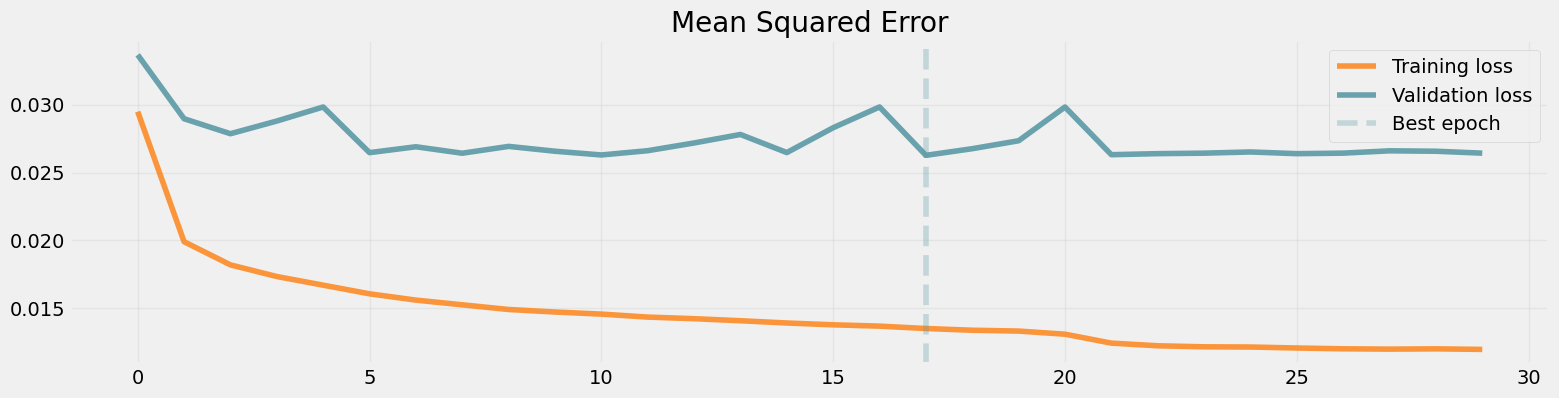

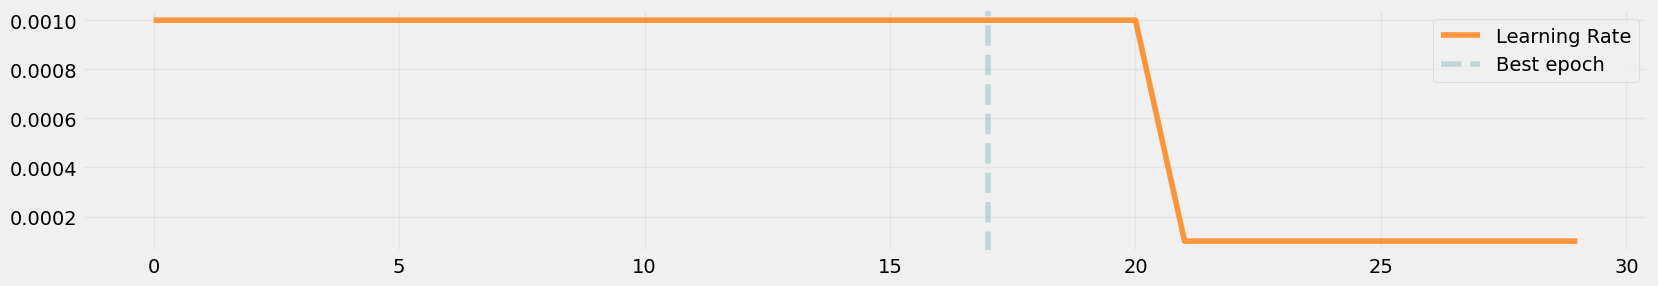

Lowest validation loss: 0.026271
Lowest training loss: 0.011956
Predictions shape: (5840, 18)
Mean Squared Error: 0.01421362441033125
Mean Absolute Error: 0.07997799664735794


In [ ]:
model_v3 = build_CONV_LSTM_model(input_shape, output_shape)
history_v3 = model_v3.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history
model_history_plot(history_v3)
calculate_error_of_model(model_v3, X_test, y_test)

In [ ]:
model_v3.save("/content/drive/MyDrive/Colab Notebooks/RedstoneRookies/Homework_2/CONVLSTM_v3.h5")
del model_v3

## Model v4
A bidirectional LSTM model.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Conv1D, Dropout, BatchNormalization, Bidirectional
import tensorflow.keras.layers as tfkl
import tensorflow as tf

def build_CONV_LSTM_model_v4(input_shape, output_shape):
    # Define the input layer with shape 200
    input_layer = Input(shape=(input_shape[1:]), name = 'input_layer')

    # Conv layers with batch normalization
    x = Conv1D(filters=32, kernel_size=3, activation='relu', name='conv1')(input_layer)
    x = BatchNormalization(name='batch_norm1')(x)
    x = Dropout(0.2, name='dropout1')(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', name='conv2')(x)
    x = BatchNormalization(name='batch_norm2')(x)

    # Bidirectional LSTM
    x = Bidirectional(LSTM(units=128, return_sequences=True), name="bidirectional_lstm1")(x)
    x = Dropout(0.2, name='dropout2')(x)
    x = Bidirectional(LSTM(units=64), name="bidirectional_lstm2")(x)

    # Output
    output_layer = Dense(units=output_shape)(x)

    # Construct the model by connecting input and output layers
    model = Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model


Epoch 1/500
737/737 [==============================] - 37s 39ms/step - loss: 0.0218 - val_loss: 0.0303 - lr: 0.0010
Epoch 2/500
737/737 [==============================] - 28s 38ms/step - loss: 0.0168 - val_loss: 0.0288 - lr: 0.0010
Epoch 3/500
737/737 [==============================] - 28s 38ms/step - loss: 0.0158 - val_loss: 0.0275 - lr: 0.0010
Epoch 4/500
737/737 [==============================] - 28s 38ms/step - loss: 0.0151 - val_loss: 0.0279 - lr: 0.0010
Epoch 5/500
737/737 [==============================] - 28s 38ms/step - loss: 0.0147 - val_loss: 0.0273 - lr: 0.0010
Epoch 6/500
737/737 [==============================] - 28s 38ms/step - loss: 0.0142 - val_loss: 0.0262 - lr: 0.0010
Epoch 7/500
737/737 [==============================] - 28s 38ms/step - loss: 0.0138 - val_loss: 0.0268 - lr: 0.0010
Epoch 8/500
737/737 [==============================] - 28s 38ms/step - loss: 0.0136 - val_loss: 0.0261 - lr: 0.0010
Epoch 9/500
737/737 [==============================] - 28s 38ms/step - l

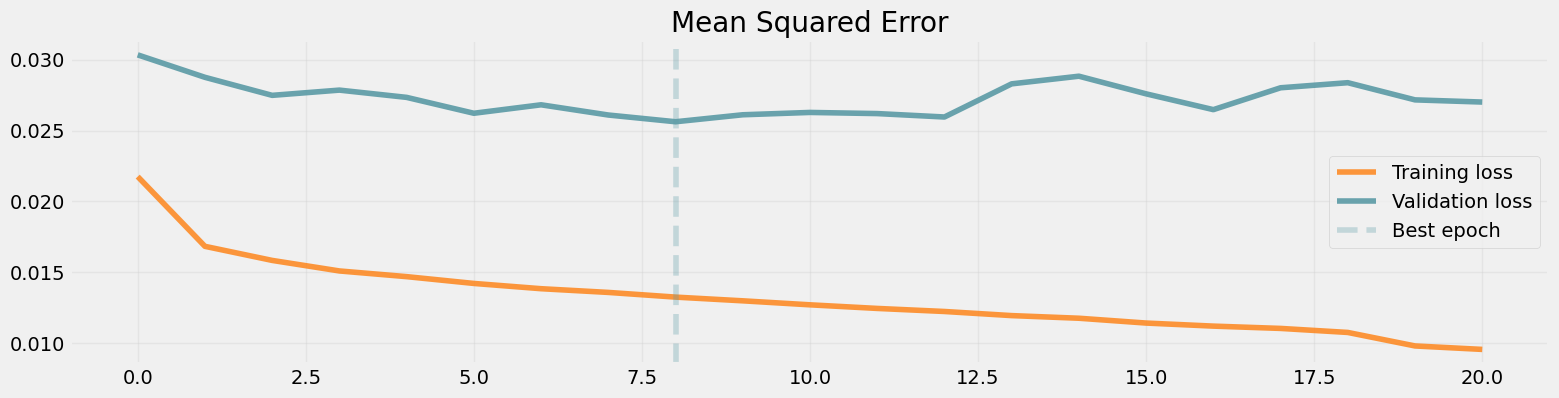

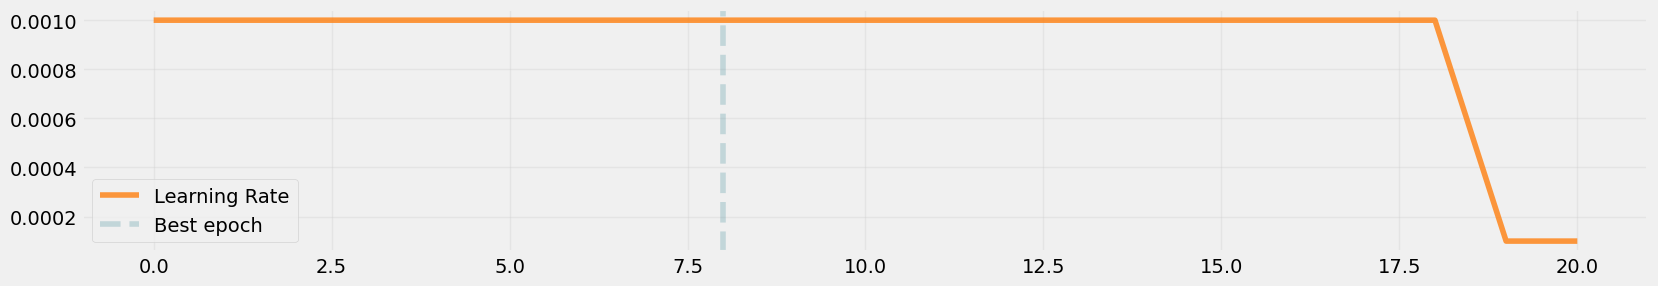

Lowest validation loss: 0.025623
Lowest training loss: 0.009564
Predictions shape: (5840, 18)
Mean Squared Error: 0.014098581857979298
Mean Absolute Error: 0.0806506872177124


In [ ]:
model_v4 = build_CONV_LSTM_model_v4(input_shape, output_shape)
history_v4 = model_v4.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history
model_history_plot(history_v4)
calculate_error_of_model(model_v4, X_test, y_test)

In [ ]:
drive.mount('/content/drive')
model_v4.save("/content/drive/MyDrive/Colab Notebooks/RedstoneRookies/Homework_2/CONVLSTM_v4.h5")
del model_v4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Robust
A model where the input data is robust scaled.

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)

tf.keras.utils.plot_model(model)

x_robust_scaled, x_medians, x_iqrs = robust_scale(X_train)
y_robust_scaled, y_medians, y_iqrs = robust_scale(y_train)

history = model.fit(
    x = x_robust_scaled,
    y = y_robust_scaled,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history



Epoch 1/500
737/737 [==============================] - 14s 13ms/step - loss: 3.3030 - val_loss: 607.1776 - lr: 0.0010
Epoch 2/500
737/737 [==============================] - 10s 14ms/step - loss: 3.2539 - val_loss: 607.2211 - lr: 0.0010
Epoch 3/500
737/737 [==============================] - 14s 19ms/step - loss: 3.2339 - val_loss: 607.2068 - lr: 0.0010
Epoch 4/500
737/737 [==============================] - 12s 16ms/step - loss: 3.2140 - val_loss: 607.1687 - lr: 0.0010
Epoch 5/500
737/737 [==============================] - 10s 13ms/step - loss: 3.1969 - val_loss: 607.1497 - lr: 0.0010
Epoch 6/500
737/737 [==============================] - 10s 14ms/step - loss: 3.1849 - val_loss: 607.1171 - lr: 0.0010
Epoch 7/500
737/737 [==============================] - 10s 13ms/step - loss: 3.1851 - val_loss: 607.1679 - lr: 0.0010
Epoch 8/500
737/737 [==============================] - 9s 13ms/step - loss: 3.1797 - val_loss: 607.1240 - lr: 0.0010
Epoch 9/500
737/737 [==============================] - 10

In [ ]:
drive.mount('/content/drive')
model.save("/content/drive/MyDrive/Colab Notebooks/RedstoneRookies/Homework_2/CONVLSTM_Robust.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Category agnostic model
We also want to try to train a model per category, in inference time we will choose the model corresponding to a given category and use this for forecasting

In [ ]:
# I.e for category 'A'
# X, y = generate_sequences_for_category("A")
def generate_sequences_for_category(category):
  timeseries_to_use = categories_df.index[categories_df["category"] == category].tolist()
  df_of_relevant_timeseries = raw_train_df.loc[timeseries_to_use].T


  return build_univariate_sequences(df_of_relevant_timeseries, valid_periods_df)


In [ ]:
def train_categories():
  categories = ['A', 'B', 'C', 'D', 'E', 'F']

  for category in categories:
    print(f"Training model for: {category}")
    X, y = generate_sequences_for_category(category)
    model = build_simple_LSTM(input_shape, output_shape)
    model.fit(
        x = X,
        y = y,
        batch_size = batch_size,
        epochs = 200,
        validation_split=.1,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
        ]
    )
    model.save(f"SimpleLSTM_ensemble_{category}.h5")
    del model
    del X
    del y

#Z-scaled

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)

tf.keras.utils.plot_model(model)

x_z_scaled, x_means, x_stds = z_scale(X_train)
y_z_scaled, y_means, y_stds = z_scale(y_train)

history = model.fit(
    x = x_z_scaled,
    y = y_z_scaled,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history



Epoch 1/500
737/737 [==============================] - 16s 14ms/step - loss: 0.8968 - val_loss: 0.9542 - lr: 0.0010
Epoch 2/500
737/737 [==============================] - 11s 14ms/step - loss: 0.8108 - val_loss: 0.9359 - lr: 0.0010
Epoch 3/500
737/737 [==============================] - 10s 14ms/step - loss: 0.7779 - val_loss: 0.9268 - lr: 0.0010
Epoch 4/500
737/737 [==============================] - 9s 13ms/step - loss: 0.7602 - val_loss: 0.9325 - lr: 0.0010
Epoch 5/500
737/737 [==============================] - 10s 14ms/step - loss: 0.7472 - val_loss: 0.9243 - lr: 0.0010
Epoch 6/500
737/737 [==============================] - 11s 14ms/step - loss: 0.7391 - val_loss: 0.9375 - lr: 0.0010
Epoch 7/500
737/737 [==============================] - 9s 13ms/step - loss: 0.7299 - val_loss: 0.9233 - lr: 0.0010
Epoch 8/500
737/737 [==============================] - 11s 14ms/step - loss: 0.7241 - val_loss: 0.9150 - lr: 0.0010
Epoch 9/500
737/737 [==============================] - 10s 14ms/step - los

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/RedstoneRookies/Homework_2/CONVLSTM_Z.h5")

# Inference

In [ ]:
drive.mount('/content/drive')
models = [
  "SimpleLSTM.h5",
"CONVLSTM_v3.h5",
"CONVLSTM_v4.h5",
"CONVLSTM_Robust.h5",
"CONVLSTM_Z.h5"
]

for model_name in models:
  print(f"Looking at model: {model_name}")
  model = tfk.models.load_model(f"/content/drive/MyDrive/Colab Notebooks/RedstoneRookies/Homework_2/{model_name}")
  print(f"Metrics for model: {model_name}")
  calculate_error_of_model(model, X_test, y_test)
  print("-"*40)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking at model: SimpleLSTM.h5
Metrics for model: SimpleLSTM.h5
Predictions shape: (5840, 18)
Mean Squared Error: 0.01444265153259039
Mean Absolute Error: 0.08051533997058868
----------------------------------------
Looking at model: CONVLSTM_v3.h5
Metrics for model: CONVLSTM_v3.h5
Predictions shape: (5840, 18)
Mean Squared Error: 0.01421362441033125
Mean Absolute Error: 0.07997799664735794
----------------------------------------
Looking at model: CONVLSTM_v4.h5
Metrics for model: CONVLSTM_v4.h5
Predictions shape: (5840, 18)
Mean Squared Error: 0.014098581857979298
Mean Absolute Error: 0.0806506872177124
----------------------------------------
Looking at model: CONVLSTM_Robust.h5
Metrics for model: CONVLSTM_Robust.h5
Predictions shape: (5840, 18)
Mean Squared Error: 0.3859821557998657
Mean Absolute Error: 0.5253852605819702
--------------------------------

## In the end we train on all the data
As we can see from training, it seems that CONVLSTM_v4 is the strongest model on the test set. For this reason this model is going to be trained on the entire set and then submitted.

In [ ]:
x_z_scaled, x_means, x_stds = z_scale(X_train)
y_z_scaled, y_means, y_stds = z_scale(y_train)

x_z_scaled_test, x_means_test, x_stds_test = z_scale(X_test)
y_z_scaled_test, y_means_test, y_stds_test = z_scale(y_test)

In [ ]:
# Train on all data
final_model = build_CONV_LSTM_model(input_shape, output_shape)
final_history = final_model.fit(
    x = X_total,
    y = y_total,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/500
820/820 [==============================] - 18s 19ms/step - loss: 0.0292 - val_loss: 0.0312 - lr: 0.0010
Epoch 2/500
820/820 [==============================] - 11s 13ms/step - loss: 0.0195 - val_loss: 0.0318 - lr: 0.0010
Epoch 3/500
820/820 [==============================] - 10s 13ms/step - loss: 0.0179 - val_loss: 0.0278 - lr: 0.0010
Epoch 4/500
820/820 [==============================] - 11s 14ms/step - loss: 0.0171 - val_loss: 0.0290 - lr: 0.0010
Epoch 5/500
820/820 [==============================] - 11s 14ms/step - loss: 0.0164 - val_loss: 0.0280 - lr: 0.0010
Epoch 6/500
820/820 [==============================] - 11s 14ms/step - loss: 0.0159 - val_loss: 0.0270 - lr: 0.0010
Epoch 7/500
820/820 [==============================] - 10s 13ms/step - loss: 0.0155 - val_loss: 0.0278 - lr: 0.0010
Epoch 8/500
820/820 [==============================] - 12s 15ms/step - loss: 0.0152 - val_loss: 0.0291 - lr: 0.0010
Epoch 9/500
820/820 [==============================] - 12s 14ms/step - l

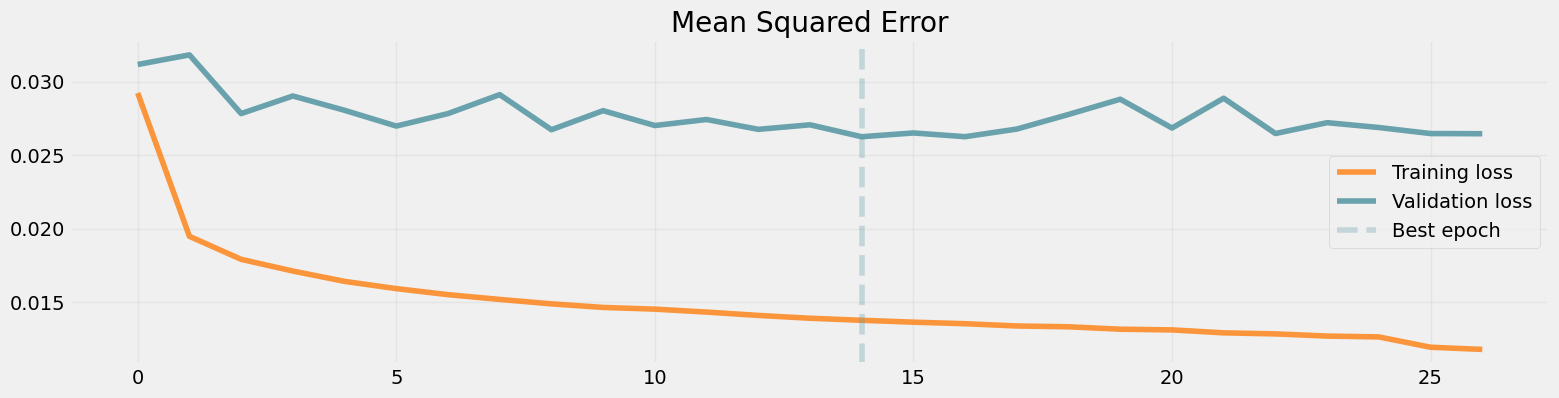

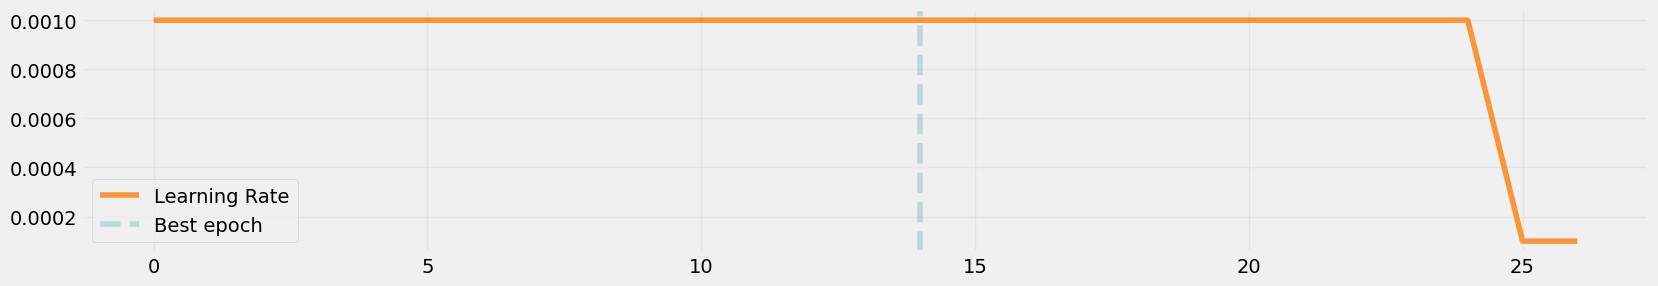

Lowest validation loss: 0.026251
Lowest training loss: 0.011779


In [ ]:
model_history_plot(final_history)
final_model.save("/content/drive/MyDrive/Colab Notebooks/RedstoneRookies/Homework_2/final_submission_final.h5")